In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 334ms/step - loss: 195.6115 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 194.9002 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 193.7610 - mae: 194.0105
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 191.7773 - mae: 192.4086
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 185.2863 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 182.3494 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 32ms/step - loss: 179.0415 - mae: 179.8091
Epoch 10/100
8/8 [==============================] - 0s 31ms/step - loss: 175.7151 - mae: 176.0967
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 29ms/step - loss: 43.3045 - mae: 43.1192
Epoch 88/100
8/8 [==============================] - 0s 29ms/step - loss: 48.1578 - mae: 49.8181
Epoch 89/100
8/8 [==============================] - 0s 34ms/step - loss: 66.7083 - mae: 66.4313
Epoch 90/100
8/8 [==============================] - 0s 35ms/step - loss: 64.3240 - mae: 65.8434
Epoch 91/100
8/8 [==============================] - 0s 33ms/step - loss: 49.8781 - mae: 50.6273
Epoch 92/100
8/8 [==============================] - 0s 32ms/step - loss: 27.4434 - mae: 28.3915
Epoch 93/100
8/8 [==============================] - 0s 31ms/step - loss: 25.6475 - mae: 25.5003
Epoch 94/100
8/8 [==============================] - 0s 33ms/step - loss: 39.1915 - mae: 40.1151
Epoch 95/100
8/8 [==============================] - 0s 32ms/step - loss: 38.3585 - mae: 39.2130
Epoch 96/100
8/8 [==============================] - 0s 33ms/step - loss: 41.2766 - mae: 41.7386
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

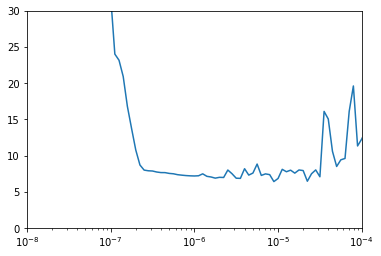

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 223ms/step - loss: 158.9032 - mae: 161.9757
Epoch 2/400
8/8 [==============================] - 0s 31ms/step - loss: 46.1350 - mae: 46.0125
Epoch 3/400
8/8 [==============================] - 0s 28ms/step - loss: 31.7904 - mae: 32.9679
Epoch 4/400
8/8 [==============================] - 0s 28ms/step - loss: 20.6319 - mae: 21.3699
Epoch 5/400
8/8 [==============================] - 0s 30ms/step - loss: 16.2197 - mae: 16.7973
Epoch 6/400
8/8 [==============================] - 0s 30ms/step - loss: 11.6516 - mae: 12.2771
Epoch 7/400
8/8 [==============================] - 0s 31ms/step - loss: 8.1615 - mae: 8.6877
Epoch 8/400
8/8 [==============================] - 0s 33ms/step - loss: 7.4532 - mae: 7.9624
Epoch 9/400
8/8 [==============================] - 0s 33ms/step - loss: 7.0567 - mae: 7.5043
Epoch 10/400
8/8 [==============================] - 0s 33ms/step - loss: 6.6110 - mae: 7.1252
Epoch 11/400
8/8 [==============================] - 0s

8/8 [==============================] - 0s 33ms/step - loss: 5.1593 - mae: 5.6458
Epoch 88/400
8/8 [==============================] - 0s 28ms/step - loss: 5.0425 - mae: 5.5217
Epoch 89/400
8/8 [==============================] - 0s 29ms/step - loss: 5.0110 - mae: 5.5243
Epoch 90/400
8/8 [==============================] - 0s 28ms/step - loss: 5.0351 - mae: 5.5118
Epoch 91/400
8/8 [==============================] - 0s 35ms/step - loss: 5.0686 - mae: 5.5608
Epoch 92/400
8/8 [==============================] - 0s 32ms/step - loss: 5.0556 - mae: 5.5670
Epoch 93/400
8/8 [==============================] - 0s 30ms/step - loss: 5.0985 - mae: 5.5938
Epoch 94/400
8/8 [==============================] - 0s 31ms/step - loss: 5.0656 - mae: 5.5234
Epoch 95/400
8/8 [==============================] - 0s 28ms/step - loss: 5.0342 - mae: 5.5078
Epoch 96/400
8/8 [==============================] - 0s 29ms/step - loss: 5.0665 - mae: 5.5013
Epoch 97/400
8/8 [==============================] - 0s 30ms/step - loss: 

8/8 [==============================] - 0s 29ms/step - loss: 4.9364 - mae: 5.4048
Epoch 174/400
8/8 [==============================] - 0s 31ms/step - loss: 4.8740 - mae: 5.3287
Epoch 175/400
8/8 [==============================] - 0s 31ms/step - loss: 4.8513 - mae: 5.3548
Epoch 176/400
8/8 [==============================] - 0s 33ms/step - loss: 4.7593 - mae: 5.2377
Epoch 177/400
8/8 [==============================] - 0s 29ms/step - loss: 4.7907 - mae: 5.2587
Epoch 178/400
8/8 [==============================] - 0s 29ms/step - loss: 4.7025 - mae: 5.1814
Epoch 179/400
8/8 [==============================] - 0s 30ms/step - loss: 4.7449 - mae: 5.2163
Epoch 180/400
8/8 [==============================] - 0s 28ms/step - loss: 4.7158 - mae: 5.2075
Epoch 181/400
8/8 [==============================] - 0s 29ms/step - loss: 4.7673 - mae: 5.2609
Epoch 182/400
8/8 [==============================] - 0s 32ms/step - loss: 4.7625 - mae: 5.2192
Epoch 183/400
8/8 [==============================] - 0s 32ms/ste

8/8 [==============================] - 0s 28ms/step - loss: 4.6406 - mae: 5.1204
Epoch 260/400
8/8 [==============================] - 0s 32ms/step - loss: 4.6362 - mae: 5.1155
Epoch 261/400
8/8 [==============================] - 0s 28ms/step - loss: 4.6074 - mae: 5.0865
Epoch 262/400
8/8 [==============================] - 0s 30ms/step - loss: 4.5849 - mae: 5.0311
Epoch 263/400
8/8 [==============================] - 0s 28ms/step - loss: 4.5830 - mae: 5.0606
Epoch 264/400
8/8 [==============================] - 0s 30ms/step - loss: 4.5540 - mae: 5.0400
Epoch 265/400
8/8 [==============================] - 0s 29ms/step - loss: 4.5716 - mae: 5.0643
Epoch 266/400
8/8 [==============================] - 0s 29ms/step - loss: 4.6182 - mae: 5.0887
Epoch 267/400
8/8 [==============================] - 0s 29ms/step - loss: 4.7420 - mae: 5.2179
Epoch 268/400
8/8 [==============================] - 0s 29ms/step - loss: 4.5566 - mae: 5.0295
Epoch 269/400
8/8 [==============================] - 0s 29ms/ste

8/8 [==============================] - 0s 31ms/step - loss: 4.5805 - mae: 5.0277
Epoch 346/400
8/8 [==============================] - 0s 30ms/step - loss: 4.6799 - mae: 5.1328
Epoch 347/400
8/8 [==============================] - 0s 30ms/step - loss: 4.5854 - mae: 5.0547
Epoch 348/400
8/8 [==============================] - 0s 40ms/step - loss: 4.5023 - mae: 4.9953
Epoch 349/400
8/8 [==============================] - 0s 31ms/step - loss: 4.4942 - mae: 4.9541
Epoch 350/400
8/8 [==============================] - 0s 28ms/step - loss: 4.4995 - mae: 4.9918
Epoch 351/400
8/8 [==============================] - 0s 29ms/step - loss: 4.5263 - mae: 4.9533
Epoch 352/400
8/8 [==============================] - 0s 29ms/step - loss: 4.4730 - mae: 4.9354
Epoch 353/400
8/8 [==============================] - 0s 30ms/step - loss: 4.5171 - mae: 4.9966
Epoch 354/400
8/8 [==============================] - 0s 29ms/step - loss: 4.5354 - mae: 5.0060
Epoch 355/400
8/8 [==============================] - 0s 28ms/ste

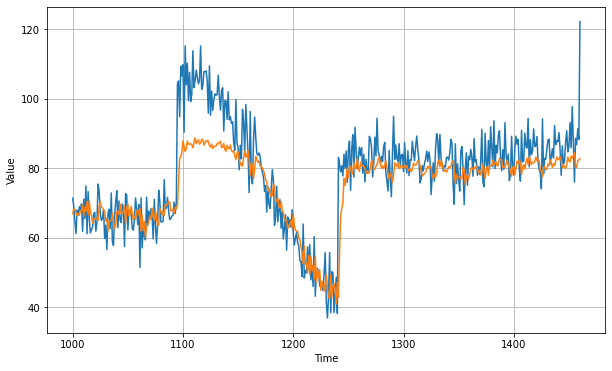

In [11]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.1454587

<Figure size 432x288 with 0 Axes>

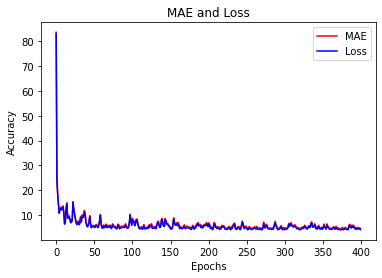

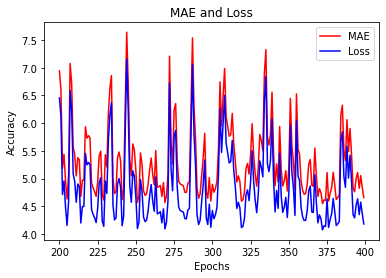

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()